### Random Numbers and Sampling: Intro to Monte Carlo

In [1]:
%matplotlib inline
import numpy as np
from scipy.fft import fft
from scipy.special import lambertw
import matplotlib.pyplot as plt
from math import factorial
from numba import jit

# constants
import scipy.constants as sc
k = sc.value('Boltzmann constant')
k_Hz = sc.value('Boltzmann constant in Hz/K')
h = sc.value('Planck constant')
c = sc.c
sigmaSB = sc.value('Stefan-Boltzmann constant')

plt.rcParams['figure.dpi'] = 150

##### Generating random numbers

An important class of algorithms relies upon using random numbers. You may well ask, since the computer is a deterministic machine, how does one obtain random behavior from it? Philosophically, one cannot, leading some people to insist on calling seemingly-random sequences of numbers generated by machine *pseudo-random* numbers. In practise one can use an analog of the Turing test for artificial intelligence: if one generates a stream of numbers and one *cannot tell* that they are not random, they *are* random for all practical purposes.

How to get such numbers? The best advice is to use a *good* random number generator (RNG). What is good? Unless you have reason to believe otherwise, accept the advice of experts in this rather arcane field. That said, there are a variety of features which characterize "good" RNGs, only some of which are relevant to physics computations. 

Virtually all useful RNGs are actually periodic functions: eventually, they will begin giving the same set of numbers over again. The key is to have that period so large that one will never see this behavior in a practical computation. The "Mersenne Twister" has a period which is a Mersenne Prime: $2^n-1$. The value often used is $2^{19937}-1$; this should be suffient for nearly any purpose!

Given a long period, we should be able to get "independent" samples of random numbers large enough by starting the sequence at some arbitrary location in the sequence. All good RNGs take a "seed" -- a number which is turned into a starting location in the sequence. The seed is *not* the starting location itself! Seeds which differ by one should give widely-separated starting points.

Clearly we want whatever sample of $N$ numbers we use to have whatever distribution they purport to
be drawn from. The basic output is most often uniform random numbers on $[0,1)$. Clearly, the sequence $(1,\dots,N-1)/N$ would satisfy this criterion, but nobody would call these random numbers! Some, but by no means all, other tests are:
1. Runs up and runs down. One can compute the probability of getting $n$ successively greater numbers in a random sample; the result of our RNG should be the same, statistically.
2. Periodicities: we expect the power spectrum of a vector of random numbers to be flat.
3. Space-filling: if one samples $k$ points as coordinates of a point in $k$-dimensional space, these points should uniformly fill that space. Many common RNG's fail this test; the points instead lie in $k-1$ dimensional planes, and often in not too many of these planes.

Consider this last test. Suppose we had a really bad RNG whose points, taken in groups of three, filled a small number of 2-dimensional planes. This would prevent us from fairly sampling 3-dimensional space!

Once parallel computing became common, RNGs faced a new challenge: how to get some number of independent
sequences of random numbers. If one knows that one will need $N$ numbers per processor, one should be able to expect that each of these sequences will be independent. One way to do this is to have the ability to skip ahead $N$ numbers in the sequence so the processor's samples will not overlap.

One test which is important for some applications but irrelevant to physics calculations is predictability.
Given $n$ random numbers from the sequence, how hard is it to predict what the next sample will be? In other words, how hard is it to reverse-engineer the RNG? This is clearly important in cryptographic applications, but nobody will be trying to guess the next number in your physics simulations! Some cryptographic
RNGs are good for this purpose, but make lousy RNGs for simulations.

Finally, one wants the RNG to be as fast as possible -- of course!

***

Numpy's default generator is the "permuted congruential generator" PCG64, a pretty good choice for general purposes.

To use it:

In [2]:
# Always use a seed -- don't rely upon some silly way to pick a "random" seed.
seed = 102983
rng = np.random.default_rng(seed)

N = 10000000
x = rng.uniform(size=N)
print(x)

[0.93423472 0.59174505 0.70896129 ... 0.06252692 0.76067931 0.21816977]


Histogram of distribution

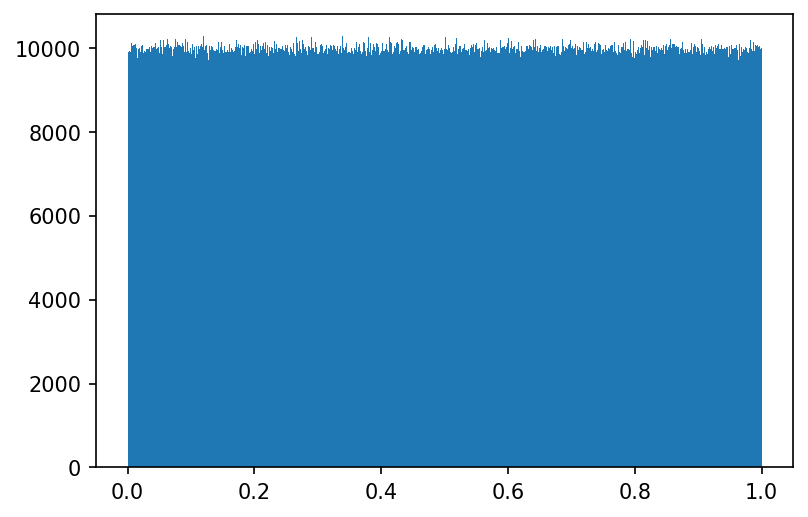

In [3]:
fig,ax = plt.subplots()
ax.hist(x, bins=1000);

Increasing sequences (I think I have the logic right...)

In [4]:
up = np.zeros((5, N))
up[1,:-1] = x[1:] < x[:-1]
up[2,:-2] = np.logical_and(up[1,:-2], up[1,1:-1]) # one up1 followed by another
up[3,:-3] = np.logical_and(up[2,:-3], up[1,2:-1]) # one up2 followed by an up1
up[4,:-4] = np.logical_and(up[3,:-4], up[1,3:-1]) # one up3 followed by an up1
print([np.count_nonzero(up[i,1:]) for i in range(1,5)])

[5000959, 1668453, 416651, 83183]


The expected number follows; we will need a statistical test to determine significance.

This doesn't seem quite right... Need to check the derivation!

In [5]:
def Erun(N,r):
    return 2*( (r**2+3*r+1)*N - (r**3+3*r**2-r-4))/factorial(r+3)
print([Erun(N,i) for i in range(1,5)])

[4166666.75, 1833333.1, 527777.6472222222, 115079.3238095238]


Power spectrum of the sequence

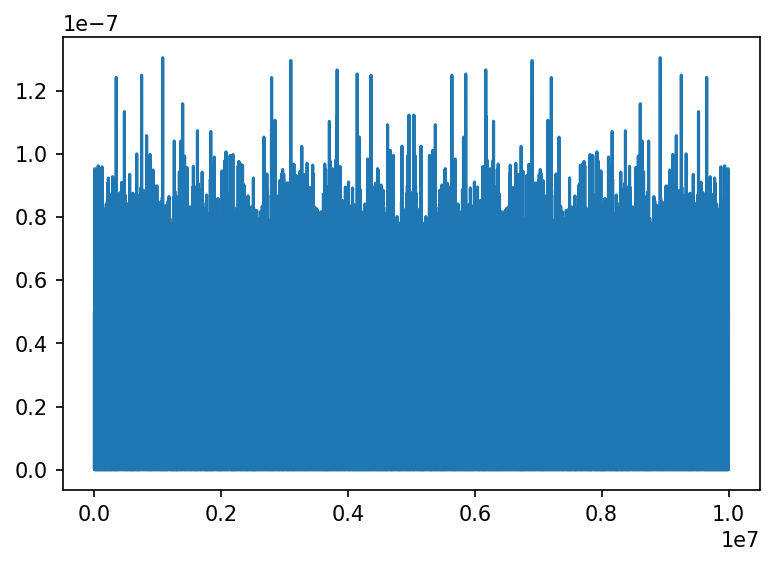

In [6]:
xhat = fft(x)/N
fig, ax = plt.subplots()
ps = np.abs(xhat[1:])**2
ax.plot(ps);

<hr style="border:2px solid gray"> </hr>

##### Sampling from Other Distributions: Transformation

So it seems that our RNG gives us *uniform random deviates* $\xi$ with a *probability density*
$$ Prob(x \le \xi < x+dx) = p(x)dx = \left\{\begin{array}{ll} dx, & 0\le x<1\\0,& \textrm{otherwise} \end{array}\right. $$
and a *cumulative probability*
$$ Prob(\xi<x) = P(x) = \int_{-\infty}^x p(x)dx = \left\{\begin{array}{ll}0,&x<0\\x,&0\le x<1 \\1,&x\ge1  \end{array}\right. $$

Given this source uniform random deviates, how do we transform them into samples from some other distribtion?

If we wish to sample from some probability distribution $y(x)$, and if $y(x)$ is a continuous, non-decreasing
function of $x$, then for some pair of values $x$ and $z$,
$$ z\le x \implies y(z) \le y(x) $$
From this we can infer that the probability of choosing a value of $z$ such that $z\le x$ must be the same as the probability of a value $y$ such that $y(z)\le y(x)$:
$$ P\{ z\le x\} = P\{ y(z) \le y(z)\} $$
The left-hand side of this expression is just the cumulative probability of the $x$'s, $F_x(x)$, and the right-hand side is the cumulative probability of the $y$'s, $F_y(y)$, so we have
$$ F_y(y(x)) = F_x(x) $$

The probability distribution function (pdf) associated with the cumulative distribution $F_x(x)$ is
$$ f_x(x) = \frac{dF_x(x)}{dx} $$
so we have
$$ \frac{d}{dx} F_y(y(x)) = \frac{d}{dx} F_x(x)$$
which is
$$ \frac{d}{dy} F_y(y) \frac{dy}{dx} = \frac{d}{dx} F_x(x)$$
which, finally, is
$$ f_y(y) = f_x(x) \frac{dx}{dy} $$

This is the fundamental law of transformation of probabilities. If $y(x)$ we of opposite slope, then
$F_y(x) = 1-F_x(x)$ since probabilities are positive. In general, then, we have
$$ f_y(y) = \left| \frac{dx}{dy} \right| f_x(x) $$

How do we use this? If we wish to sample from some pdf $f_y(dy)$ and we have a source of uniform random deviates for which $f_x(x) = 1$, we have the differential equation 
$$ f_y(y) = \frac{dx}{dy} $$
for a positive function $f_y(y)$ whose integral is one. This is just the indefinate integral $F_y(y)$ (the cumulative distribution function, cdf). The transformation which takes the uniformly-distributed $\xi$ into
the one distributed as $f_y(y)$ is then obtained by solving
$$ F_y(y) = \xi $$
for $y$, or
$$ y = F^{-1}_y(\xi) $$
This is the *transformation method* of sampling from a distribution $f_y(y)$.


As a rather obvious first example, let's say we wish to chose a uniform deviate on some other range than $[0,1)$, say $[a,b)$. The pdf is
$$ f(y(x) = \left\{\begin{array}{ll}0,&x<a\\1,&a\le x<b \\0,&x\ge b  \end{array}\right. $$
The cumulative distribution, properly normalized is
$$ f_y(y) = \frac{\int_a^y f_y(t)dt}{\int_a^b f_y(t)dt} = \frac{y-a}{b-a} $$
Setting this equal to $F_\xi(\xi)$ and solving for $y$, we have
$$ y = (b-a)\xi + a $$

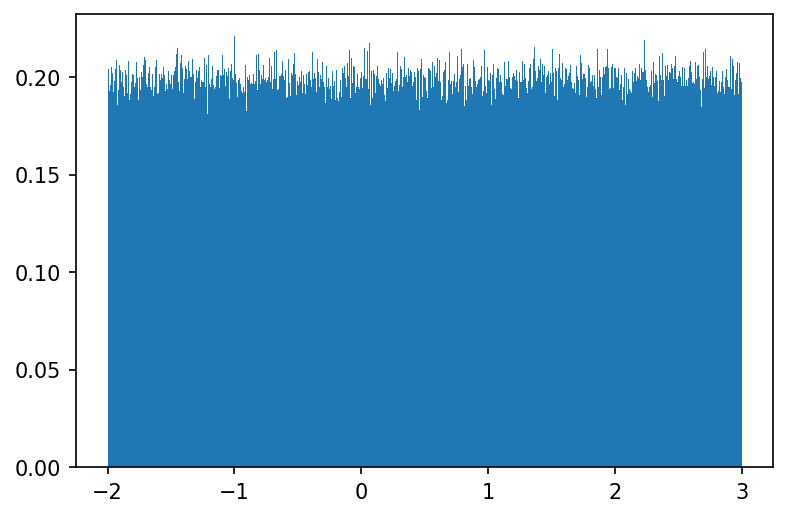

In [7]:
N = 10**6
a, b = -2, 3
xi = rng.uniform(size=N)
x = (b-a)*xi + a
fig, ax = plt.subplots()
ax.hist(x, bins=1000, density=True);

A less trivial example is sampling from the exponential distribution, with pdf
$$ f_y(y) = \lambda e^{-\lambda x},\quad 0\le y < \infty $$
The cumulative distribution is
$$ F_y(y) = \int_0^y \lambda e^{-\lambda t} dt = 1 - e^{-\lambda y} $$
Inverting this function, we have
$$ y = -\frac{1}{\lambda} \ln(1-\xi) $$
Since $1-\xi$ is distributed identically as $\xi$, we have, finally,
$$ y = -\frac{1}{\lambda}\ln(\xi) $$
Now, as $\xi$ samples the unit interval, $y$ samples the range $[0,\infty)$ with probability proportional to $e^{-\lambda y}$.

Since our computers are fast enough, we'll take $10^6$ samples and make a histogram with $10^3$ bins, and overplot the distribution we are trying to sample:

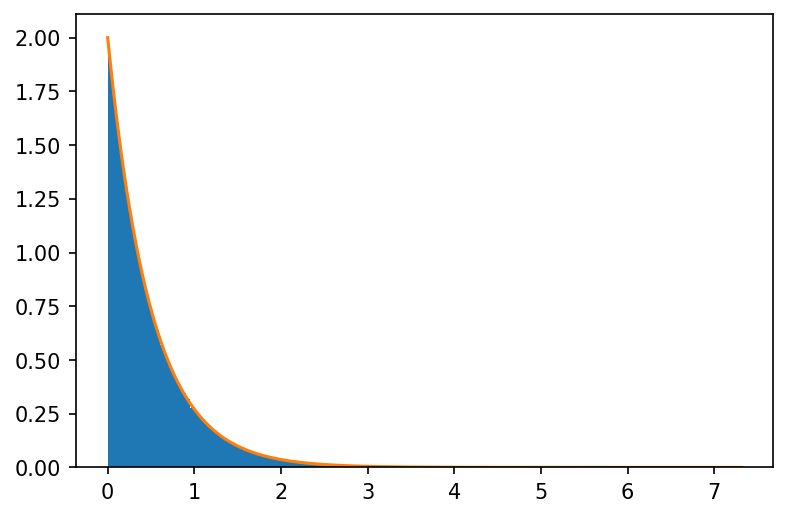

In [8]:
N = 10**6
xi = rng.uniform(size=N)
y = -np.log(xi)/2

fig, ax = plt.subplots()
n, bins, p = ax.hist(y, bins=1000, density=True) # density=True normalizes the histogram (divides by N)
ax.plot(bins, 2*np.exp(-2*bins));

Graphically, the scheme looks like this for sampling $\sin(x)$ on $[0,\frac{\pi}{2})$. The cumulative distribution is
$$ F(y) = \int_0^y \sin(t) dt = 1-\cos(x) $$
since probabilities must be positive. Thus, we must solve
$$ 1- \cos(x) = \xi \implies x = \cos^{-1}(1-\xi) = \cos^{-1}(\xi)$$
We come in on the y-axis with a value of $\xi \in[0,1)$, and then go down to the x-axis to find the sampled value:

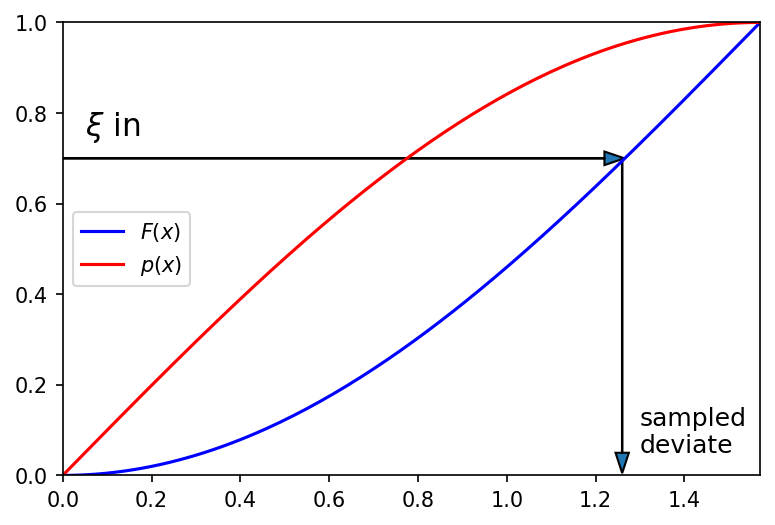

In [9]:
x = np.arange(0,0.5*np.pi,.01)
fig, ax= plt.subplots()
ax.set_xlim(0,np.pi/2)
ax.set_ylim(0,1)
ax.plot(x,1-np.cos(x),'b', label=r'$F(x)$')
ax.plot(x, np.sin(x),'r', label=r'$p(x)$')
ax.arrow(0,.7,1.22,0, head_width=0.03)
ax.arrow(1.26,.7, 0, -.65, head_width=0.03)
ax.text(0.05,.75,r'$\xi$ in', fontsize=15)
ax.text(1.3, 0.05, 'sampled\ndeviate', fontsize=12)
ax.legend(loc=6);

Try it out:

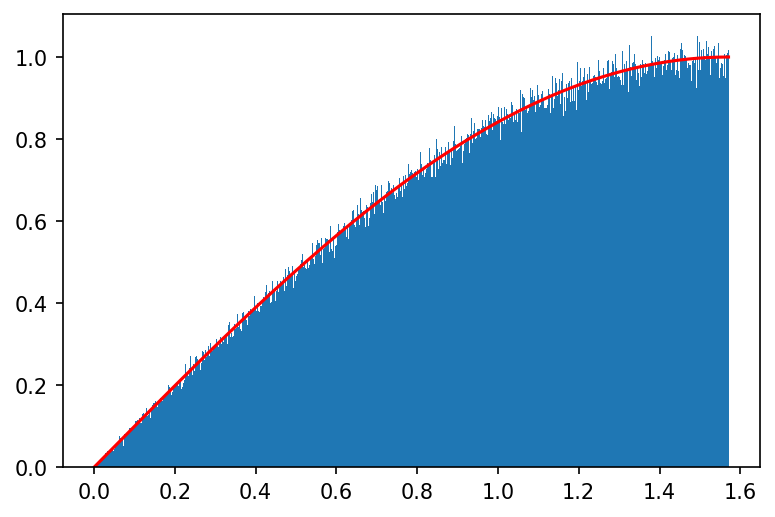

In [10]:
N = 10**6
xi = rng.uniform(size=N)
y = np.arccos(xi)

fig, ax = plt.subplots()
tmp, bins, tmp = ax.hist(y, bins=1000, density=True);
ax.plot(bins, np.sin(bins),'r');

How might you sample $\sin(x)$ on $[0,2\pi)$?

Let's try sampling from a power-law distribution $y(x) = x^{-\alpha}$ with $x\in[a,b]$.
We have 
\begin{align}
 F(x) &= \frac{\int_a^x t^{-\alpha} dt}{\int_a^b t^{-\alpha} dt} \\
 &= \frac{ \left.t^{1-\alpha}\right|_a^x }{ \left.t^{1-\alpha}\right|_a^b }
\end{align}
and thus
$$ x = (a^{1-\alpha} + \xi(b^{1-\alpha}-a^{1-\alpha}))^{1/(1-\alpha)} $$

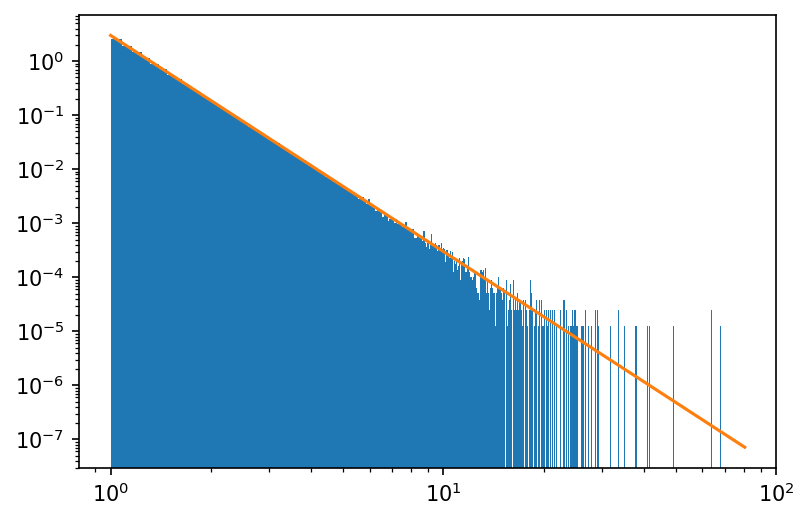

In [11]:
def sampPowerlaw(a, lo, hi):
    return (lo**(1-a) + rng.uniform()*(hi**(1-a)-lo**(1-a))) ** (1/(1-a))

N = 10**6
a = 4
lo, hi = 1, 100
y = [ sampPowerlaw(a, lo, hi) for i in range(N) ]

fig, ax = plt.subplots()
tmp, bins, tmp = ax.hist(y, bins=1000, density=True);
ax.set_xscale('log')
ax.set_yscale('log')

fac = (hi**(1-a)-lo**(1-a))/(1-a)
ax.plot(bins, bins**(-a)/fac);

<hr style="border:2px solid gray"> </hr>

Often one cannot analytically invert the cumulative distribution function. The field of Monte Carlo calculations is replete with clever tricks. For example, we can use the following simple trick to sample from
a Gaussian. The Central Limit Theorem tells us that the sum of a number of samples from *any* distribution will be distributed as a Gaussian distribution. Let's try this out:

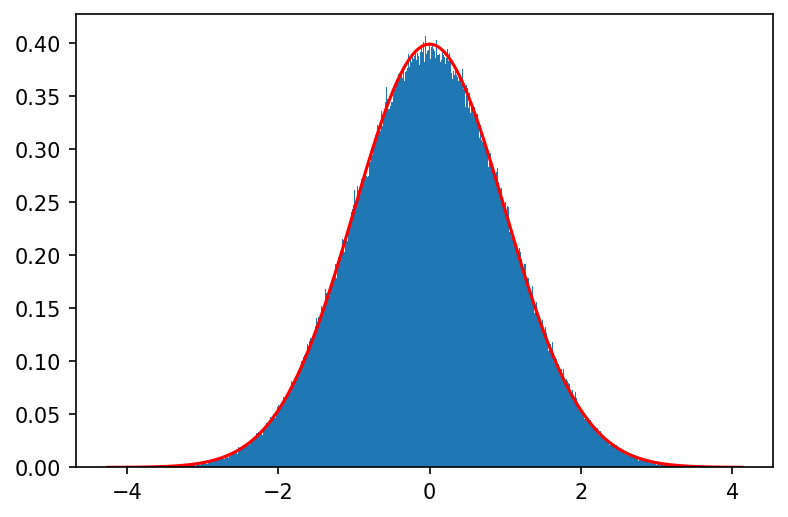

In [12]:
def trickyGaussian(M, N):
    return [np.sum(rng.uniform(size=M))-M/2 for i in range(N)]

N = 10**6
y = trickyGaussian(12, N)

fig, ax = plt.subplots()
n, bins, p = ax.hist(y, bins=1000, density=True);
ax.plot(bins, 1/(np.sqrt(2*np.pi))*np.exp(-bins**2/2),'r');

The Central Limit Theorem doesn't say how quickly the sum of samples approaches a Gaussian, and in fact it approaches very quickly near the peak but convergence becomes much slower further out on the distribution. So this trick works if you don't care much about the far tails of the distribution!

We can also generalize the transformation method to functions of more than one dimension.
In this case, $dx/dy$ becomes the Jacobian determinant $\left|\partial \mathbf{x}/\partial \mathbf{y}\right|$.

The most famous example is the Box-Muller method for sampling from a Gaussian. If we sample two uniform deviates $\xi_1$ and $\xi_2$ we can write
$$
\begin{split}
y_1 &= \sqrt{-2\ln \xi_1} \cos(2\pi \xi_2) \\
y_2 &= \sqrt{-2\ln \xi_1} \sin(2\pi \xi_2) 
\end{split}
$$
Soving for the $\xi$'s, this is
\begin{align*}
\xi_1 &= e^{(-y_1^2 + y_2^2)/2}\\
\xi_2 &= \frac{1}{2\pi}\tan^{-1}\frac{y_2}{y_1}
\end{align*}
Computing the Jacobian
$$ \left| \begin{array}{ll} \frac{\partial \xi_1}{\partial y_1} & \frac{\partial \xi_1}{\partial y_2}\\
\frac{\partial \xi_2}{\partial y_1} & \frac{\partial \xi_2}{\partial y_2} \end{array} \right| 
= -\left[\frac{1}{\sqrt{2\pi}}e^{-y_1^2/2}\right]\left[\frac{1}{\sqrt{2\pi}}e^{-y_2^2/2}\right]
$$
we see this is the product to two, independent Gaussians. Each pair of $\xi$ thus yields two samples drawn from the same Gaussian distribution.

In [13]:
def boxMuller(x1, x2):
    fac = np.sqrt(-2*np.log(x1))
    return np.array([fac * np.cos(2*np.pi*x2), fac * np.sin(2*np.pi*x2)])

N = 10**6
xi = rng.uniform(size=N)
result = boxMuller(xi[:N//2],xi[N//2:]).flatten()

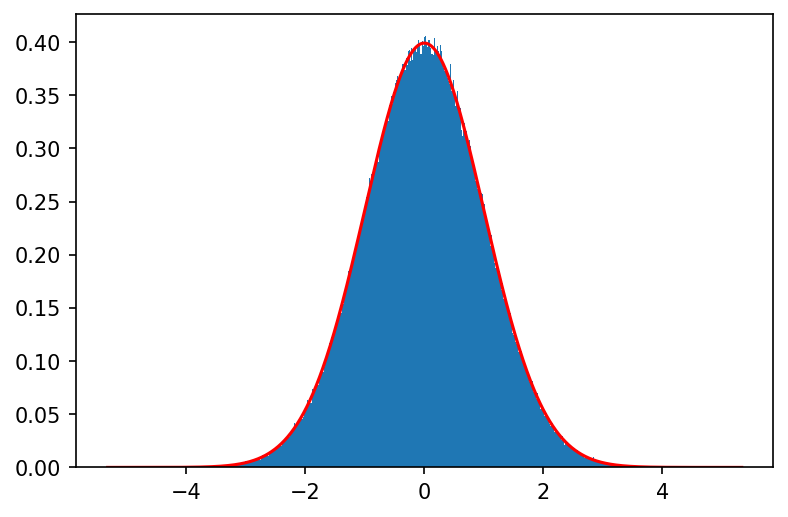

In [14]:
fig, ax = plt.subplots()
n, bins, p = ax.hist(result, bins=1000, density=True);
ax.plot(bins, 1/(np.sqrt(2*np.pi))*np.exp(-bins**2/2),'r');
ax.set_aspect('auto')

<hr style="border:2px solid gray"> </hr>

##### Rejection Sampling

In cases where one cannot easily determine the inverse of the cumulative distribution function one can try the *acceptance-rejection method*. 

If the pdf from which we desire to sample, $p(x)$, cannot be directly inverted, we can try a modification known as the *acceptance-rejection* method. Define a function $f(x)$ which is everywhere greater than $p(x)$
with a cumulative distribution
$$ F(x) = \int_{\infty}^x f(t) dt $$
By definition, it will not be normalized since $\int p(x) dx = 1$, but let
$$ A = \int_{-\infty}^\infty f(t) dt  > 1$$
Let $F$ be easily invertable, so we can use the transformation method above to sample from it.

The method is then:
1. Pick a uniform random deviate $x$ on $[0,A)$: $x = (b-a)\xi_1 + a$
2. Determine the value $y = F^{-1}(x)$
3. By definition, $f(y)>p(y)$. Choose another uniform random deviate $\xi_2$ and accept the value $y$ if 
$$ \frac{p(y)}{f(y)} < \xi_2 $$
otherwise, try again.

The value is accepted on average $1/A$ of the time.

Take as an example the normal distribution again. This time, since the function is symmetric, we'll sample only for positive values of $x$:
$$ p(x) = \frac{2}{\sqrt{2\pi}}e^{-x^2/2} $$
We pick as our $f$ the distribution
$$ f(x) = e^{-|x|/2} $$
It is easily seen that everywhere $f(x)>p(x)$, and the cumulative distribution is
$$ F(x) = 2 - 2e^{-x/2} $$
with $F\in[0,2)$. Since $\lim_{y\rightarrow\infty}F(y) = 2$, about half of the values are accepted, for
an efficiency of 50\%.

The inverse of $F$ is
$$ x = -2\ln(1-F/2) $$
Since we are sampling from $F^{-1}$, this is the same as
$$ x = -2\ln(\xi) $$

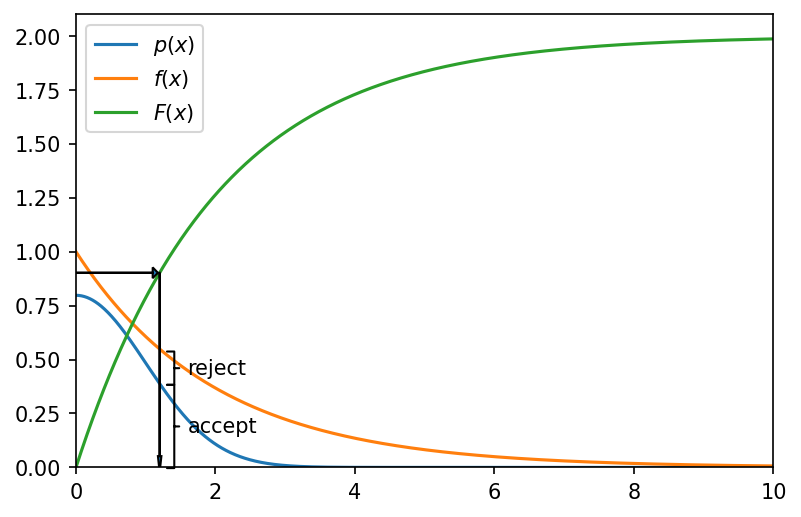

In [15]:
def p(x):
    return 2/(np.sqrt(2*np.pi)) * np.exp(-x**2/2)

def f(x):
    return np.exp(-np.abs(x)/2)

def F(x):
    return 2*(1 - np.exp(-x/2))

def Finv(xi):
    return -2*np.log(xi)

fig, ax = plt.subplots()
ax.set_xlim(0,10)
ax.set_ylim(0,2.1)
x = np.linspace(0,10, 1000)
ax.plot(x,p(x), label=r'$p(x)$')
ax.plot(x,f(x), label=r'$f(x)$')
ax.plot(x,F(x), label=r'$F(x)$')
ax.legend()
ax.arrow(0, 0.9023, 1.1, 0, head_width=0.05, zorder=10)
ax.arrow(1.2,0.9023, 0, -0.85, head_width=0.05, zorder=10)

ax.annotate('accept', xy=(1.35, 0.19), xytext=(1.6, 0.19), #xycoords='axes fraction', 
            fontsize=10, ha='left', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.35', lw=1.0))
ax.annotate('reject', xy=(1.35, 0.46), xytext=(1.6, 0.46), #xycoords='axes fraction', 
            fontsize=10, ha='left', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=0.8, lengthB=0.35', lw=1.0));

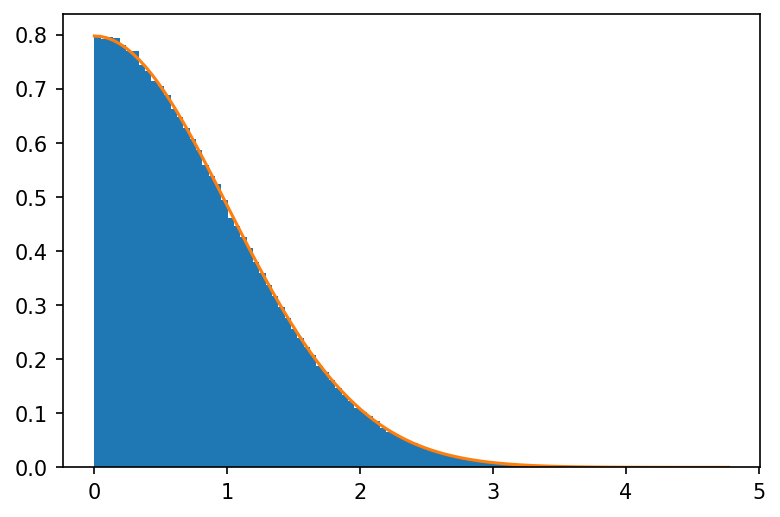

In [16]:
def sampNorm():
    while True:
        xi = rng.uniform()
        x = -2*np.log(xi)
        xi = rng.uniform()
        if xi < p(x)/f(x):
            return x
        
N = 10**6
y = [ sampNorm() for i in range(N) ]

fig, ax = plt.subplots()
tmp, bins, tmp = ax.hist(y, bins=100, density=True)
ax.plot(bins, p(bins));

If you want to sample from the full distribution, simply mirror half the values:

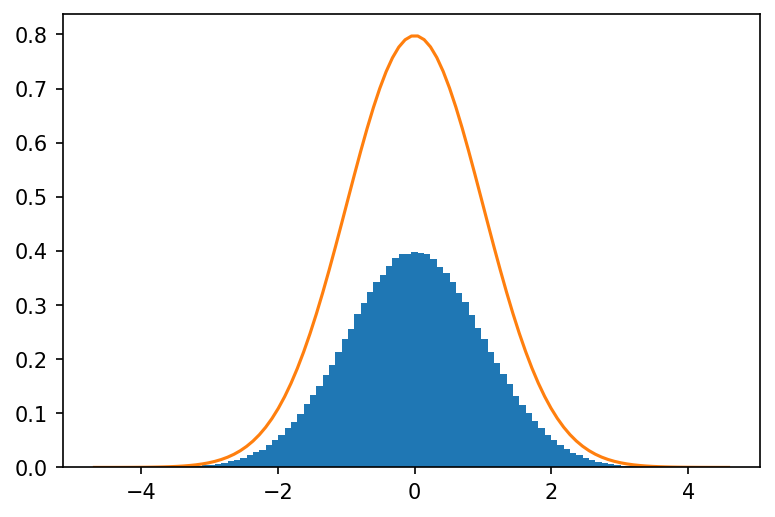

In [17]:
def sampNormBoth():
    while True:
        xi = rng.uniform()
        x = -2*np.log(xi)
        xi = rng.uniform()
        if xi < p(x)/f(x):
            if rng.uniform() < 0.5:
                return -x
            else:
                return x
        
N = 10**6
y = [ sampNormBoth() for i in range(N) ]
fig, ax = plt.subplots()
n, bins, tmp = ax.hist(y, bins=100, density=True)
ax.plot(bins, p(bins));

<hr style="border:2px solid gray"> </hr>

To sample from the weighted sum of distributions
$$ p(x) = \sum_i w_i f_i(x), \  \textrm{with}\ \sum_i w_i = 1 $$

Compute the cumulative sum of the weights
$$ W_i = \sum_{j=1}^i w_j $$
and then pick $\xi_1$, find the index $i$ such that $W_{i-1} < \xi < W_i$, and sample $f_i(x)$.

For example, to sample from the sum of three normal distributions
$$ p(x) = \frac{1}{4} N(x,\mu=-3, \sigma=2) + \frac{1}{2} N(x,\mu=0,\sigma=1) + \frac{1}{4} N(x,\mu=5,\sigma=2) $$

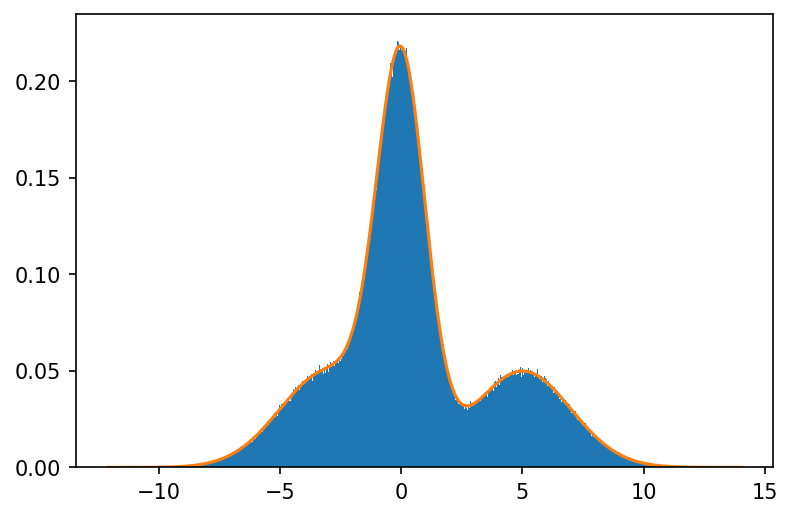

In [18]:
def p(x, mu=0, s=1):
    return 1/(np.sqrt(2*np.pi)*s) * np.exp(-0.5*(x-mu)**2/s**2)

def f(x,mu=0,s=1):
    return np.exp(-0.5*np.abs(x-mu)/s)

def sampNormal(mu=0, s=1):
    while True:                      # use rejection method
        xi = rng.uniform()           # use change of variable to sample from 
        x = -2*np.log(xi)            # unit sigma and zero mean
        xi = rng.uniform()
        if xi < 2*p(x)/f(x):         # one-sided gaussian here (factor of two)
            if rng.uniform() < 0.5:  # made two-sided here & change of variable
                return -x*s + mu
            else:
                return x*s + mu

def sampleSum():
    w1, w2, w3 = 1/4,1/2,1/4         # weights
    W1 = w1                          # cumulative weights
    W2 = w1+w2
    xi1= rng.uniform()

    if xi1 < W1:
        return sampNormal(mu=-3, s=2)
    elif xi1 < W2:
        return sampNormal(mu=0, s=1)
    else:
        return sampNormal(mu=5, s=2)
                
N = 10**6
y = [ sampleSum() for i in range(N) ]

fig, ax = plt.subplots()
tmp, bins, tmp = ax.hist(y, bins=1000, density=True)
ans = 0.25*p(bins, mu=-3, s=2) + 0.5*p(bins, mu=0, s=1) + 0.25*p(bins, mu=5, s=2)
ax.plot(bins, ans)

<hr style="border:2px solid gray"> </hr>

On D2L I have placed a copy of "A Third Monte Carlo Sampler" (C.J.Evrett & E.D. Cashwell 1983, Los Alamos technical report LA-9721-MS). This is perhaps the most complete collection of methods for sampling from just about any
physically-useful mathematical distribution function.

To sample from an integer power, $p(x) = (n+1)x^n$, we can use transformation to
write
$$ x = (\xi)^{1/(n+1)} $$

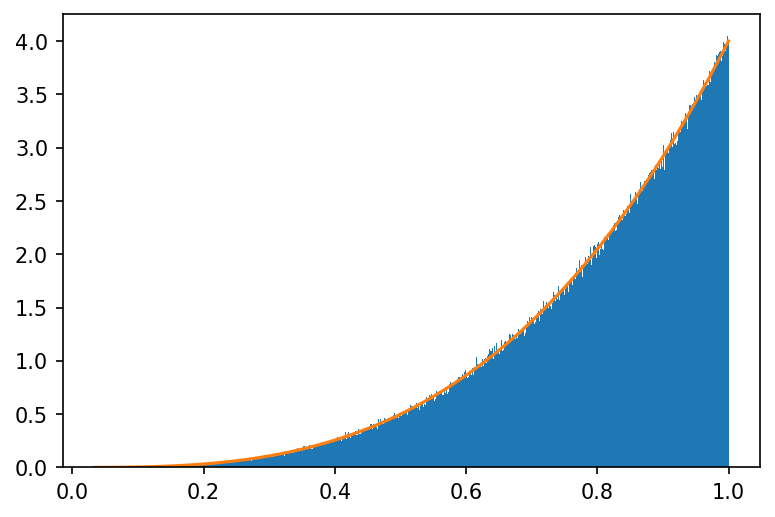

In [19]:
def sampPower(n):
    xi = rng.uniform()
    return xi**(1/(n+1))

n = 3
N = 10**6
xi = rng.uniform(size=N)
y = [ sampPower(n) for i in range(N) ]
fig, ax = plt.subplots()
tmp, bins, tmp = ax.hist(y, bins=1000, density=True)
ax.plot(bins, (n+1)*bins**n);

We can also sample from $(n+1)x^n$ by 
$$ x = \min(\xi_1,\dots,\xi_{n+1}) $$
Can you explain why?

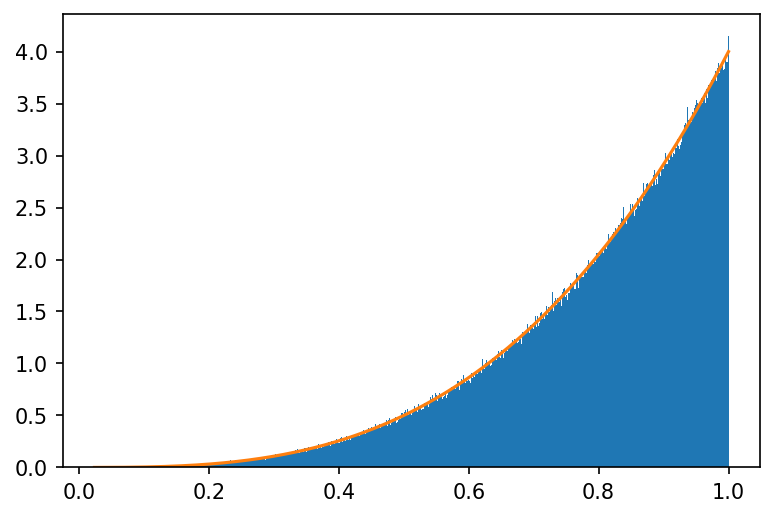

In [20]:
def sampPowerAlt(n):
    xi = rng.uniform(size=(n+1))
    return np.max(xi)

n=3
N = 10**6
xi = rng.uniform(size=(N,4))
y = [ sampPowerAlt(n) for i in range(N) ]
fig, ax = plt.subplots()
tmp, bins, tmp = ax.hist(y, bins=1000, density=True)
ax.plot(bins, (n+1)*bins**n);

To sample from
$$\frac{m^{(n+1)}}{n!}x^{n} e^{-m x}$$
we take
$$ x = -\frac{1}{m}\ln(\prod_{i=1}^{n+1} \xi_i)$$
This is useful for sampling Rayleigh and Maxwell-Boltzmann distributions.

For example, to sample 
$$ p(x) = \frac{1}{2} x^2 e^{-2x} $$
we have

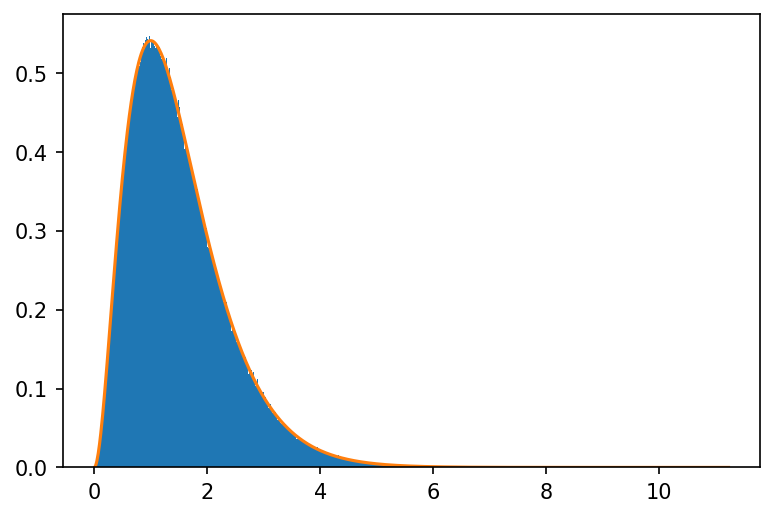

In [21]:
def sampPowerExp(n, m):
    xi = rng.uniform(size=(n+1))
    return -np.log(np.prod(xi))/m

n=2
m=2
N = 10**6
y = [ sampPowerExp(n,m) for i in range(N) ]
fig, ax = plt.subplots()
tmp, bins, tmp = ax.hist(y, bins=1000, density=True)
ax.plot(bins, (m**(n+1)/factorial(n))*bins**(n)*np.exp(-m*bins));

<hr style="border:2px solid gray"> </hr>

This brings us to the first method for sampling from a Planck distribution, a frequent need in astrophysical simulations.

The Planck function is
$$ B_\nu(T) = \frac{2h\nu^3}{c^2} \frac{1}{e^{h\nu/kT}-1} $$
for which the pdf is
$$ p(x) = \frac{15}{\pi^4} \frac{1}{e^x-1} $$
(of course, only for $x\ge0$).

Write this as
$$ p(x) = \frac{15}{\pi^4} \frac{e^{-x}}{1-e^{-x}} $$
We can now use the expansion
$$ \frac{1}{1-x} = \sum_{k=0}^\infty x^k,\quad 0< x< 1 $$
to write our pdf as
$$ \frac{15}{\pi^4} e^{-x} \sum_{k=0}^\infty e^{-kx} $$
With a bit more manipulation, this is
$$ p(x) = \sum_{k=1}^\infty \left(\frac{90}{\pi^4} \frac{1}{k^4}\right)\left(\frac{k^4}{6} x^3 e^{-kx}\right) $$
Define 
$$  f_k(x) = \frac{k^4}{6} x^3 e^{-kx} \ \textrm{and}\ w_k = \frac{90}{\pi^4}\frac{1}{k^4} $$
and so we have
$$ p(x) = \sum_{k-1}^\infty w_k f_k(x) $$
where
$$ \sum_{k=1}^\infty w_k = 1 $$
and $f_k(x)$ is a pdf (it's integral is one).

Thus, the power series is a weighted sum from which we know how to sample using the algorithm above.

The algorithm is then
1. Sample $\xi_1$ and find $n$ such that 
$$\xi_1 \le \sum_{k=1}^n w_k$$
   This is the first step in sampling from a weighted sum of distribtions.   
   <br>
   
2. Now we know which distribution to sample, use this value of $n$ to sample the pdf
$$ f_n(x) = \frac{n^4}{6} x^3 e^{-nx} $$
   using the method above for $\frac{m^{(n+1)}}{n!}x^{n} e^{-m x}$, namely
$$x = -\frac{1}{k}\ln(\prod_{i=1}^{4} \xi_i) $$


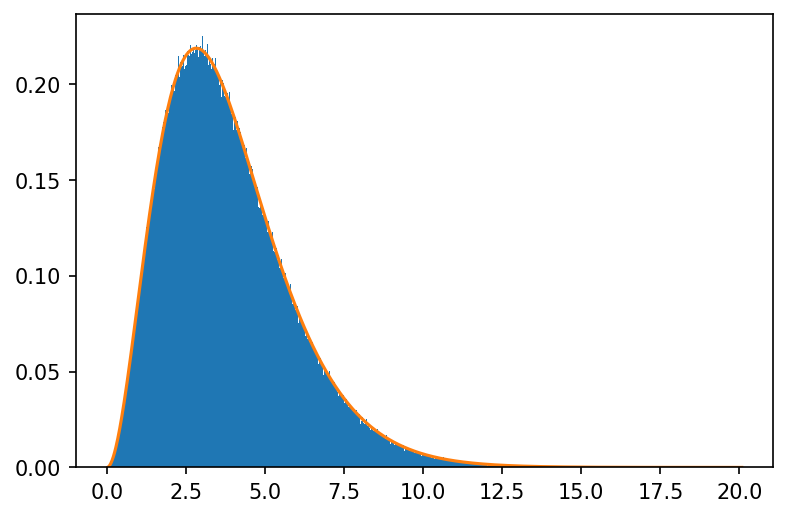

In [22]:
def sampPlanck():
    fac = np.pi**4/90 * rng.uniform()
    sum = 1
    k = 1
    while sum < fac:
        k += 1
        sum += 1/k**4 
    return -1/k * np.log(np.prod(rng.uniform(size=4)))

def planck(x):
    return 15*x**3/(np.exp(x)-1)/np.pi**4

N = 10**6
y = np.zeros(N)
x = rng.uniform(size=N)
y = [sampPlanck() for i in range(N)]

fig, ax = plt.subplots()
tmp, bins, tmp = ax.hist(y,bins=1000,density=True)
ax.plot(bins, planck(bins));

We can also sample the Planck function by rejection, as given by Barnett & Canfield (1970, "Sampling a Random Variable Distributed According to Planck's Law", Livermore Technical Report UCRL-ID-125393)

Again, starting with the pdf
$$ p(x) = \frac{15}{\pi^4} \frac{1}{e^x-1} $$
Multiply numerator and denominator by $e^{-x}$:
$$ p(x) = \frac{15}{\pi^4} \frac{e^{-x}}{1-e^{-x}} $$
Multiply numerator and denominator by $1+e^{-x}/x$
$$ p(x) = \frac{15}{\pi^4} \left(x^3 e^{-x} + x^2e^{-2x}\right)\frac{x}{(1-e^{-x})(x+e^{-2x})} $$
We can write this as 
$$ p(x) = \left[\frac{6}{6 + 1/4}\left(\frac{1}{6} x^3 e^{-x}\right) + \frac{1/4}{6+1/4}\left(4x^2e^{-2x}\right)\right] (6+1/4)\frac{15}{\pi^4}\frac{x}{(1-e^{-x})(x+e^{-2x})} $$
or 
$$ p(x) = \left(\frac{24}{25} f_1(x) + \frac{1}{25} f_2(x)\right) h(x) $$
This is the weighted sum of two pdf's times a weighting function $h(x)$ which takes on values in $(6+1/4)\frac{15}{\pi^4}[1,h_{max}]$ where $h_{max}=1.1629473863$.

With $w_1 = 24/25$, $w_2=1/25$, and $\hat{h} = (6+1/4)\frac{15}{\pi^4}h_{max}$, 
we can then sample this function as follows:
1. Choose $\xi_1$.
2. If $\xi_1<w_1$, sample $f_1(x)$ for $x$, otherwise sample $f_2(x)$ for $x$.
3. Choose $\xi_2$.
4. If $\xi_2 < h(x)/\hat{h}$, accept $x$, otherwise reject it and begin again.
Since $h(x)/\hat{h}$ has a maximum of $\approx 1.163$, the acceptance rate will be about 86%.

In [23]:
def sampPlanckAlt():
    while True:
        xi = rng.uniform()
        if xi > 24/25:
            t2 = np.prod(rng.uniform(size=3))
            x = -0.5*np.log(t2)
            t = np.sqrt(t2)
        else:
            t = np.prod(rng.uniform(size=4))
            x = -np.log(t)
        r = 1.16295 * (1-t)*(x+t) * rng.uniform()
        if r <= x:
            return x

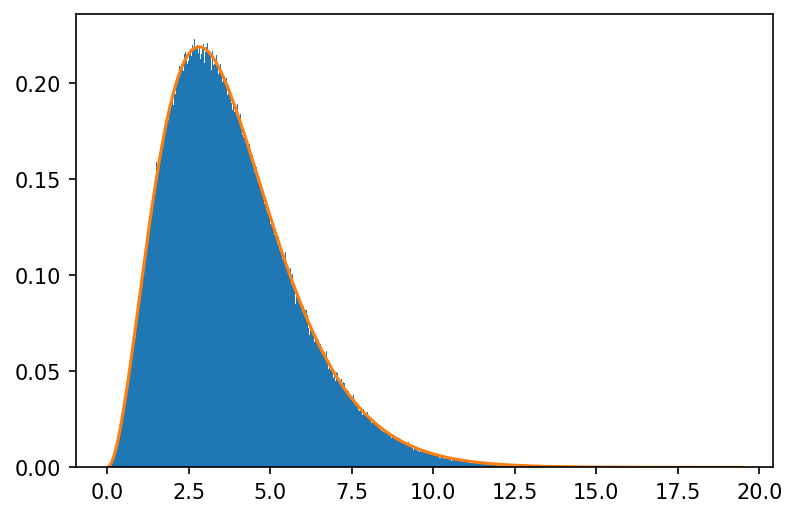

In [24]:
def planck(x):
    return 15*x**3/(np.exp(x)-1)/np.pi**4

N = 10**6
y = [ sampPlanckAlt() for i in range(N)]

fig, ax = plt.subplots()
sampled, bins, tmp = ax.hist(y,bins=1000,density=True)
ax.plot(bins, planck(bins));

Putting back the constants, we convert the sampled points to frequencies in Hz by multiplying by $kT/h$.
Since the pdf planck(x) is normalized so that its integral is one, multiplying by $\sigma_{SB} T^4$ gives
the total energy emitted per Hz. Since $B_\nu(T)$ has units of energy / time / frequency / solid angle,
we divide by $\pi$.

Were we doing a Monte Carlo calculation, each sample would "carry" a specific intensity of 
$$ I_{sample}  = \frac{\sigma_{SB} T^4}{\pi} \frac{1}{ N \Delta \nu} $$

Text(0, 0.5, '$B_\\nu(T)\\ [W\\ m^{-2}\\ ster^{-1} Hz^{-1}]$')

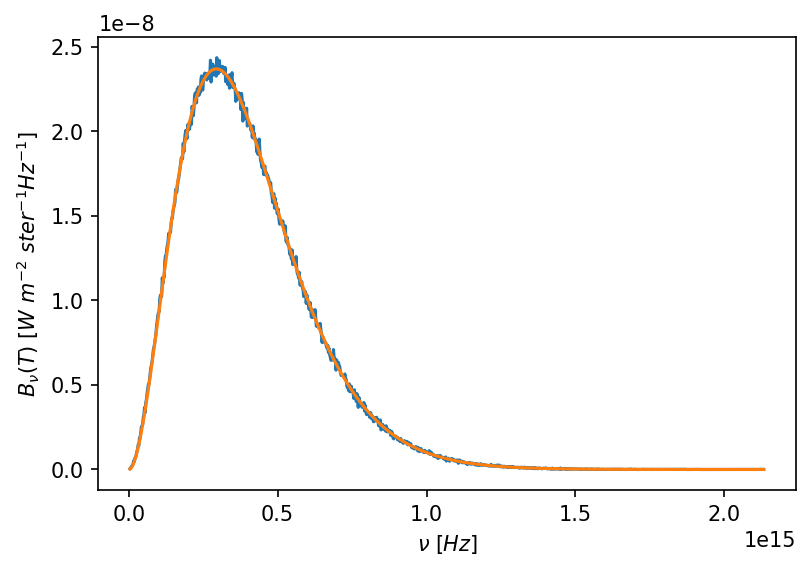

In [25]:
def PlanckFunction(nu,T):
    return 2*h*nu**3/c**2 / (np.exp(h*nu/(k*T))-1)

T = 5000

N = 10**6
y = np.array([ sampPlanckAlt() for i in range(N)]) * k*T/h

# np.histogram is the same as plt.hist, without producing a plot:
sampled, bins = np.histogram(y,bins=1000)  # note no "density=True" here

fig, ax = plt.subplots()

ax.plot(bins[:-1], sampled * sigmaSB*T**4 / np.pi /(bins[2]-bins[1])/N)

ax.plot(bins, PlanckFunction(bins,T));

ax.set_xlabel(r'$\nu\ [Hz]$')
ax.set_ylabel(r'$B_\nu(T)\ [W\ m^{-2}\ ster^{-1} Hz^{-1}]$')

As you can see from Evrett & Cashwell, many closed-form functions can be sampled quite efficiently by combinations of a few clever tricks.

In the next notebook we will introduce a method which can be used to sample from *any* pdf, even those whose normalization we either don't know or cannot compute easily.